# Capacity Tests

### Test 1: 

Sample Input: [..., #, #, A, B, C, D, E, #, #, #, X, B, C, D, Y, #, ... ]

Expected Output: The accuracy is around or greater than 0.5.


In [52]:
from SequentialGroup import Column, Group, Node, Link
from pathlib import Path
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from utils.Profiler import Profiler
from typing import Set
from utils.dataset import generate_dataset
from utils.draw_group import draw_group

figures_root = Path('Figures')


In [10]:
seq1 = ['A', 'B', 'C', 'D', 'E']
seq2 = ['X', 'B', 'C', 'D', 'Y']
seqs = [seq1, seq2]

D_train, _, dictionary = generate_dataset(seqs)
data = D_train

In [22]:
def create_model(n_columns, n_nodes):
    # Create the model
    g = Group(n_columns, n_nodes)
    g.thresh = 0.8
    g.p_plus = 2 #1.95
    g.p_minus = 0.99 #0.9
    g.p_minus2 = 0.01

    for idx, column in enumerate(g.columns):
        column.mark = idx
    return g

def test_model(g: Group, data, top1=False):
    print(len(data))
    print(data[:20])
    accuracies = []
    n_anticipations = []

    profiler = Profiler(100)
    for i, (idx, idx_next) in enumerate((tqdm(zip(data[:-1], data[1:]), total=len(data)-1))):
        candidates: Set[Node] = g.activate(idx)
        anticipations = set()
        if not top1:
            for candidate in candidates:
                anticipations.add(candidate.column.mark)
        else:
            if len(candidates) > 0:
                candidate = max(candidates, key=lambda node: node.activity_pred)
                anticipations.add(candidate.column.mark)

        ''' compute the accuracy '''
        acc = profiler.observe(anticipations, idx_next)
        accuracies.append(acc)
        ''' count the number of valid anticipations '''
        a = np.array(g.columns[idx].get_activities(), dtype=bool)
        if not all(a):
            n_anticipations.append((len(anticipations), sum(a)))
        # n_anticipations.append(len(anticipations))
        
    return accuracies, g, n_anticipations

In [32]:
def plot_curve(y, color='#1F77B4', color2="#82B0D2", window_size = 1000, y_bottom=None, y_top=None, label=None):
    s = pd.Series(y)
    s_ma = s.rolling(window=window_size, min_periods=1).mean()
    upper_quartile = s.rolling(window=window_size, min_periods=1).quantile(0.75)
    lower_quartile = s.rolling(window=window_size, min_periods=1).quantile(0.25)
    plt.plot(s, c=color2, alpha=0.3, zorder=2)
    plt.fill_between(s.index, lower_quartile, upper_quartile, color=color2, zorder=4)
    plt.plot(s_ma, color=color, label=label, zorder=6)
    plt.ylim(bottom=y_bottom, top=y_top)

80000
[3, 5, 2, 6, 0, 6, 13, 19, 3, 5, 2, 6, 0, 11, 14, 1, 4, 5, 2, 6]


100%|██████████| 79999/79999 [00:18<00:00, 4249.47it/s]


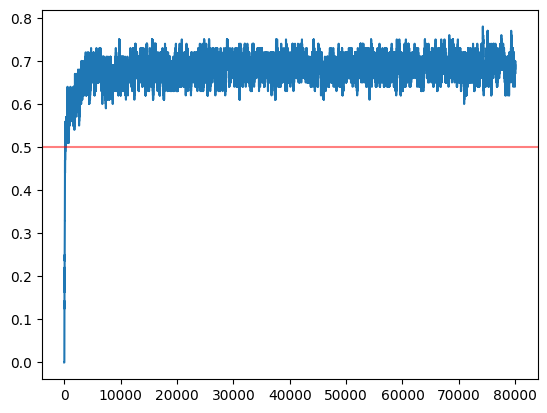

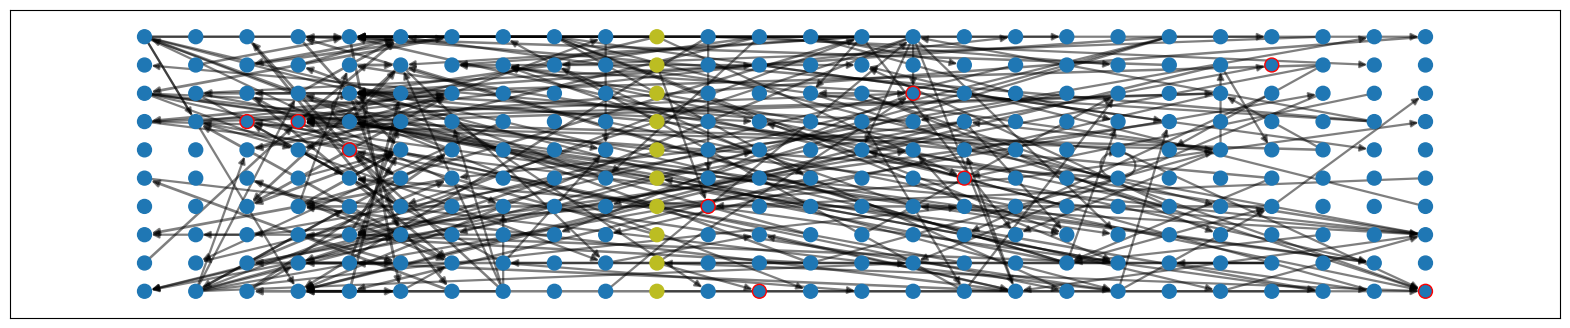

In [12]:
g1 = create_model(26, 10)
accuracies1, _, n_anticipations1 = test_model(g1, data)
plt.figure()
plt.plot(accuracies1)
plt.axhline(0.5, c='r', alpha=0.5)
draw_group(g1)
plt.show()

In [ ]:
g1_2 = create_model(26, 10)
accuracies1_2, _, n_anticipations1_2 = test_model(g1_2, data, top1=True)

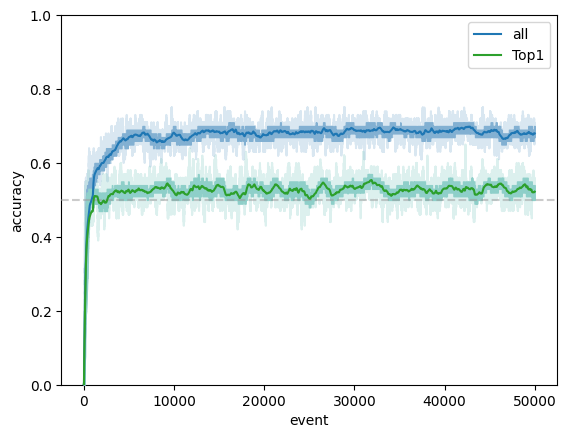

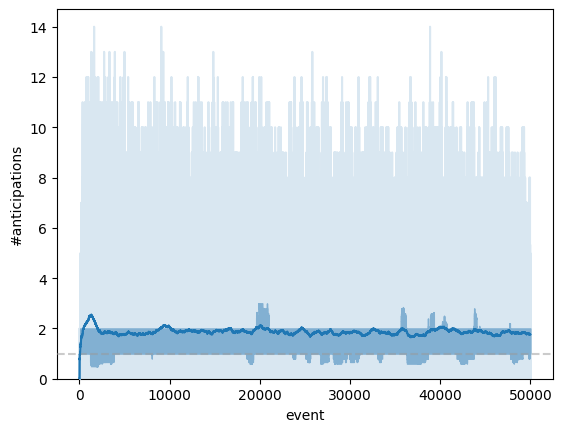

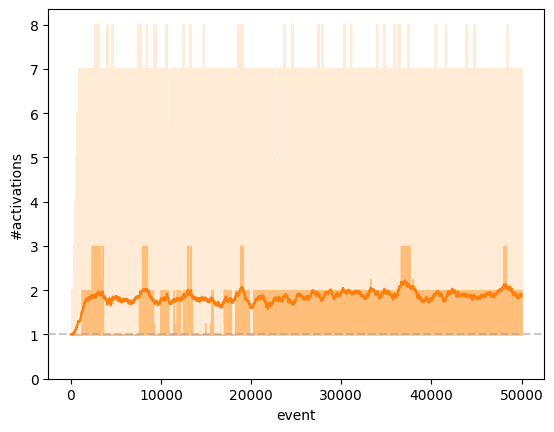

In [50]:
plt.figure()
plot_curve(accuracies1[:50000], y_bottom=0, y_top=1, label="all")
plt.axhline(0.5, color='#999999', alpha=0.5, linestyle='--', zorder=5)
plot_curve(accuracies1_2[:50000], color="#2CA02C", color2="#8ECFC9", y_bottom=0, y_top=1, label="Top1")
plt.legend(loc='upper right')
plt.ylabel("accuracy")
plt.xlabel("event")
plt.savefig(figures_root/"Capacity"/f"Accuracy-SimpleCase.pdf")
plt.figure()
plot_curve((pair[0]/pair[1] for pair in n_anticipations1[:50000]), y_bottom=0)
plt.axhline(1, color='#999999', alpha=0.5, linestyle='--', zorder=5)
plt.ylabel("#anticipations")
plt.xlabel("event")
plt.savefig(figures_root/"Capacity"/f"Anticipations-SimpleCase.pdf")
plt.figure()
plot_curve((pair[1] for pair in n_anticipations1[:50000]), color="#FF7F0E", color2="#FFBE7A", y_bottom=0)
plt.axhline(1, color='#999999', alpha=0.5, linestyle='--', zorder=5)
plt.ylabel("#activations")
plt.xlabel("event")
plt.savefig(figures_root/"Capacity"/f"Activations-SimpleCase.pdf")
plt.show()

### Test 2: 

Randomly generate some patterns of sequence.

Sample Input: length=5, n_seqs = 5

Sample Generated data: [..., #, #, X, B, A, E, K, #, #, #, I, S, L, Q, J, #, #, #, L, K, M, B, Z, #, #, #, C, V, W, T, P, #, #, #, O, H, B, X, E, #, ...]

Expected Output: The accuracy is around or greater than 0.5.

In [17]:
"""Helpers"""
def generate_seqs(length, n_patterns, n_types=26):
    from ordered_set import OrderedSet
    length = int(length)
    n_patterns = int(n_patterns)
    assert (n_patterns >= 1) and (length >= 4)
    seqs = [] # subsequences
    for _ in range(n_patterns):
        samples = OrderedSet([i for i in range(n_types)])
        seq = list(np.random.choice(samples, length))
        seqs.append(seq)
    return seqs

def test_capacity(length, n_patterns, n_types=26, n_nodes=10):
    root_cache = Path('./cache')
    root_cache.mkdir(parents=True, exist_ok=True)
    file_cache = root_cache/f"daatset_capacity-test_{length}_{n_patterns}_{n_types}.pkl"
    if not file_cache.exists():
        seqs = generate_seqs(length, n_patterns, n_types)
        D_train, D_test, dictionary = generate_dataset(seqs, length*n_patterns*200, 1000, n_chars=n_types)
        with open(file_cache, 'wb') as f:
            pickle.dump((D_train, D_test, dictionary), f)
    else:
        with open(file_cache, "rb") as f:
            D_train, D_test, dictionary = pickle.load(f)
    data = D_train[:length*n_patterns*400]
    g = create_model(n_types, n_nodes)
    accuracies, _, n_anticipations = test_model(g, data)
    return accuracies, g, n_anticipations

#### length=5, n_patterns=5, n_types=26

In [18]:
accuracies2, g2, n_anticipations2 = test_capacity(5, 5, 26, 10)
# length = 5
# n_patterns = 5
# n_types = 26
# n_nodes=10
# filename = Path('cache')/f"result-length={length}-n_patterns={n_patterns}-n_types={n_types}-n_nodes={n_nodes}.pkl"
# if not filename.exists():
#     accuracies, g, n_anticipations = test_capacity(length, n_patterns, n_types, n_nodes)
#     with open(str(filename), 'wb') as f:
#         pickle.dump((accuracies, g, n_anticipations), f)
# else:
#     with open(str(filename), 'rb') as f:
#         accuracies, g, n_anticipations = pickle.load(f)
# accuracies2, g2, n_anticipations2 = accuracies, g, n_anticipations

10000
[4, 2, 6, 13, 7, 16, 11, 14, 1, 9, 16, 11, 5, 9, 22, 22, 1, 9, 16, 11]


100%|██████████| 9999/9999 [00:01<00:00, 5829.50it/s] 


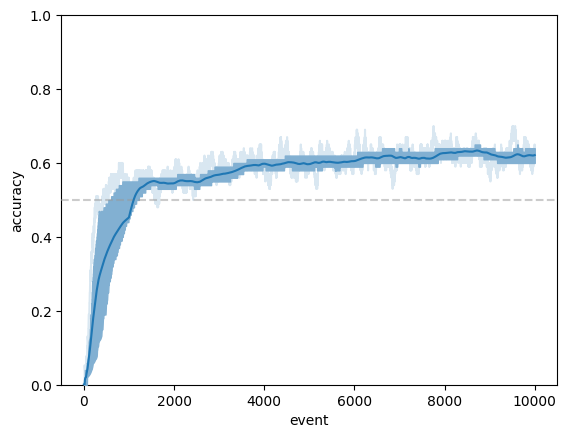

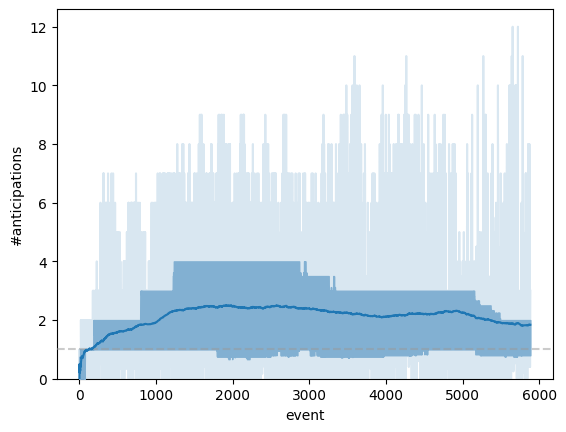

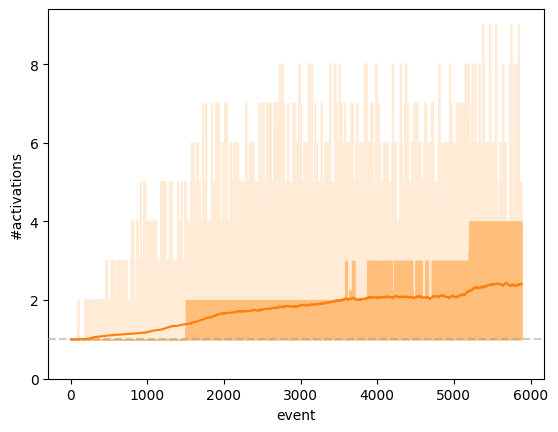

In [56]:
plt.figure()
plot_curve(accuracies2[:50000], y_bottom=0, y_top=1)
plt.axhline(0.5, color='#999999', alpha=0.5, linestyle='--', zorder=5)
plt.ylabel("accuracy")
plt.xlabel("event")
plt.savefig(figures_root/"Capacity"/f"Accuracy-length=5-n_patterns=5-n_types=26-n_nodes=10.pdf")
plt.figure()
plot_curve((pair[0]/pair[1] for pair in n_anticipations2[:50000]), y_bottom=0)
plt.axhline(1, color='#999999', alpha=0.5, linestyle='--', zorder=5)
plt.ylabel("#anticipations")
plt.xlabel("event")
plt.savefig(figures_root/"Capacity"/f"Anticipations-length=5-n_patterns=5-n_types=26-n_nodes=10.pdf")
plt.figure()
plot_curve((pair[1] for pair in n_anticipations2[:50000]), color="#FF7F0E", color2="#FFBE7A", y_bottom=0)
plt.axhline(1, color='#999999', alpha=0.5, linestyle='--', zorder=5)
plt.ylabel("#activations")
plt.xlabel("event")
plt.savefig(figures_root/"Capacity"/f"Activations-length=5-n_patterns=5-n_types=26-n_nodes=10.pdf")
plt.show()

#### length=14, n_patterns=20, n_types=26

In [20]:
accuracies3, g3, n_anticipations3 = test_capacity(14, 20, 26, 10)

112000
[10, 2, 20, 14, 15, 10, 0, 1, 17, 12, 14, 20, 8, 5, 13, 19, 16, 11, 14, 1]


100%|██████████| 111999/111999 [00:54<00:00, 2067.43it/s]


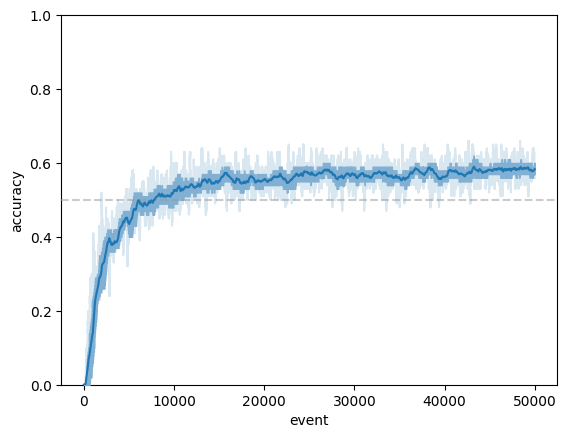

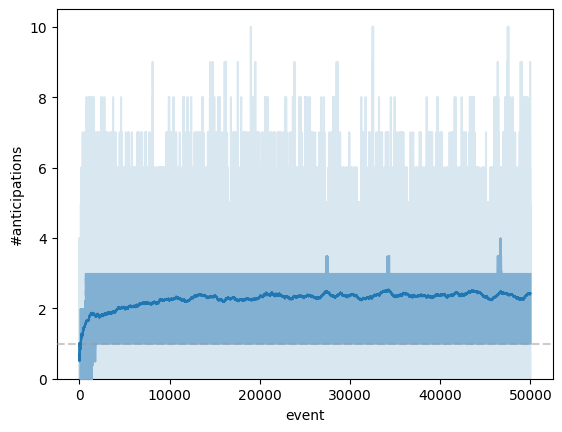

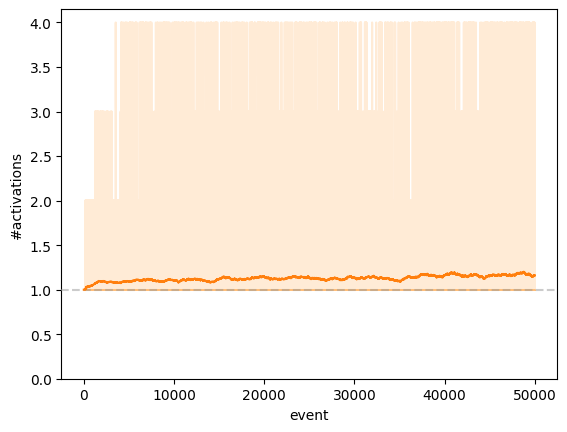

In [54]:
plt.figure()
plot_curve(accuracies3[:50000], y_bottom=0, y_top=1)
plt.axhline(0.5, color='#999999', alpha=0.5, linestyle='--', zorder=5)
plt.ylabel("accuracy")
plt.xlabel("event")
plt.savefig(figures_root/"Capacity"/f"Accuracy-length=14-n_patterns=20-n_types=26-n_nodes=10.pdf")
plt.figure()
plot_curve((pair[0]/pair[1] for pair in n_anticipations3[:50000]), y_bottom=0)
plt.axhline(1, color='#999999', alpha=0.5, linestyle='--', zorder=5)
plt.ylabel("#anticipations")
plt.xlabel("event")
plt.savefig(figures_root/"Capacity"/f"Anticipations-length=14-n_patterns=20-n_types=26-n_nodes=10.pdf")
plt.figure()
plot_curve((pair[1] for pair in n_anticipations3[:50000]), color="#FF7F0E", color2="#FFBE7A", y_bottom=0)
plt.axhline(1, color='#999999', alpha=0.5, linestyle='--', zorder=5)
plt.ylabel("#activations")
plt.xlabel("event")
plt.savefig(figures_root/"Capacity"/f"Activations-length=14-n_patterns=20-n_types=26-n_nodes=10.pdf")
plt.show()

#### length=14, n_patterns=20, n_types=1000 (26 by default)

In [47]:
accuracies4, g4, n_anticipations4 = test_capacity(14, 20, 1000, 10)

112000
[231, 205, 218, 161, 111, 94, 158, 75, 7, 121, 201, 52, 139, 175, 589, 147, 240, 331, 334, 129]


100%|██████████| 111999/111999 [01:34<00:00, 1181.52it/s]


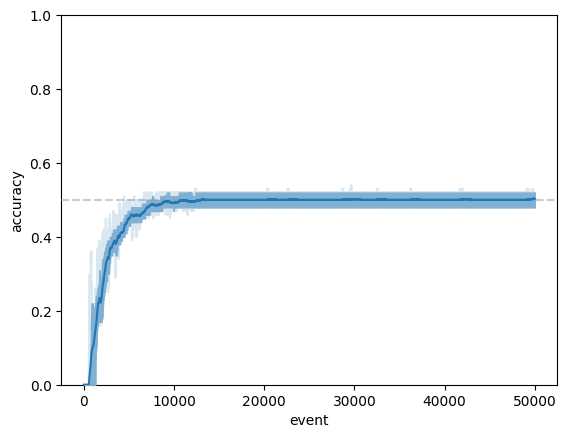

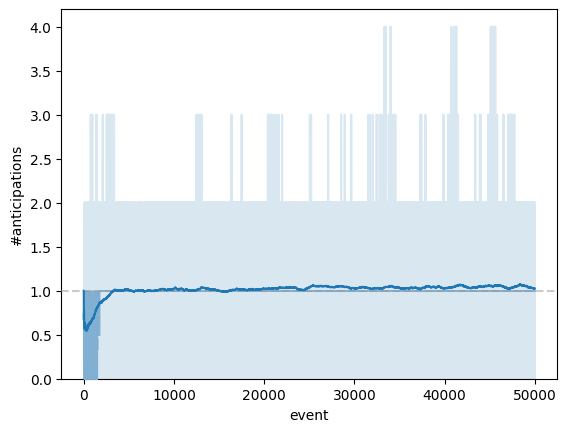

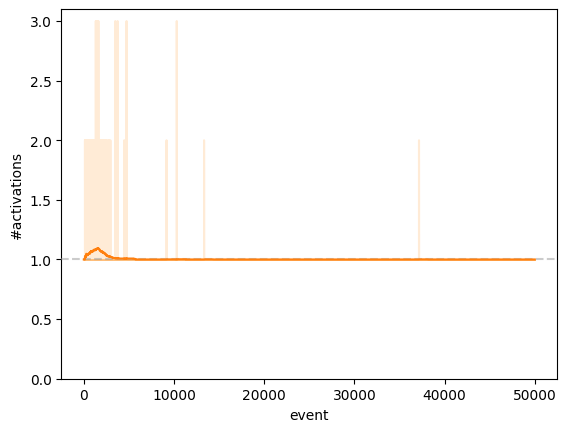

In [57]:
plt.figure()
plot_curve(accuracies4[:50000], y_bottom=0, y_top=1)
plt.axhline(0.5, color='#999999', alpha=0.5, linestyle='--', zorder=5)
plt.ylabel("accuracy")
plt.xlabel("event")
plt.savefig(figures_root/"Capacity"/f"Accuracy-length=14-n_patterns=20-n_types=1000-n_nodes=10.pdf")
plt.figure()
plot_curve((pair[0]/pair[1] for pair in n_anticipations4[:50000]), y_bottom=0)
plt.axhline(1, color='#999999', alpha=0.5, linestyle='--', zorder=5)
plt.ylabel("#anticipations")
plt.xlabel("event")
plt.savefig(figures_root/"Capacity"/f"Anticipations-length=14-n_patterns=20-n_types=1000-n_nodes=10.pdf")
plt.figure()
plot_curve((pair[1] for pair in n_anticipations4[:50000]), color="#FF7F0E", color2="#FFBE7A", y_bottom=0)
plt.axhline(1, color='#999999', alpha=0.5, linestyle='--', zorder=5)
plt.ylabel("#activations")
plt.xlabel("event")
plt.savefig(figures_root/"Capacity"/f"Activations-length=14-n_patterns=20-n_types=1000-n_nodes=10.pdf")
plt.show()

# Catastrophic-Forgetting Tests